## Import Libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
from skimage.metrics import structural_similarity as ssim
print(tf.__version__)
# Import other libraries
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2.12.0


## Load Data

In [2]:
data = np.load('public_data.npz', allow_pickle=True)
def initialize_images(data):
    images = []

    # Iterate through files in the specified folder
    for img in data:
        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        if img is not None:
            images.append(img)

    return np.array(images)

images = initialize_images(data['data'])
labels = data['labels']
outlier1, outlier2 = images[58], images[338]
outlier_idx = []
for i, image in enumerate(images):
  if np.array_equal(image, outlier1) or np.array_equal(image, outlier2):
    outlier_idx.append(i)

images = np.delete(images, outlier_idx, axis=0)
labels = np.delete(labels, outlier_idx, axis=0)
images, indices = np.unique(images, return_index=True, axis=0)
labels = labels[indices]


## Outlier Detection with isolation Forest

In [11]:
# Extract features from the images and apply Isolation Forest to detect outliers
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import cv2
from sklearn.preprocessing import FunctionTransformer

In [12]:
# image feature extraction with cv2 
def feature_extraction(images):
    features = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        features.append(cv2.HuMoments(cv2.moments(gray)).flatten())
    return np.array(features)

In [13]:
scaler = StandardScaler()
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=seed)
# define the feature_extractor, which uses the feature_extraction function, for the sklearn pipeline
feature_extractor = FunctionTransformer(feature_extraction, validate=False)

pipeline = Pipeline([('feature_extractor', feature_extractor), ('scaler', scaler), ('isolation_forest', isolation_forest)])

# Fit the pipeline
pipeline.fit(images)


Pipeline(steps=[('feature_extractor',
                 FunctionTransformer(func=<function feature_extraction at 0x00000141B05B1260>)),
                ('scaler', StandardScaler()),
                ('isolation_forest',
                 IsolationForest(contamination=0.01, random_state=42))])

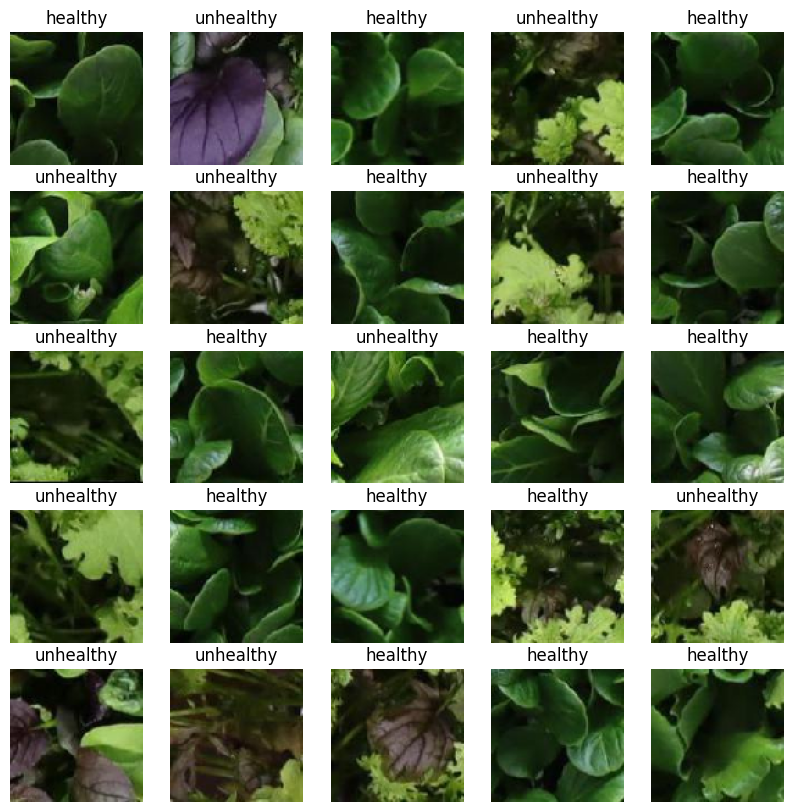

In [15]:
# Predict the outliers
outlier_predictions = pipeline.predict(images)
outlier_idx = np.where(outlier_predictions == -1)[0]

# Plot the outliers
plt.figure(figsize=(10, 10))
for i, idx in enumerate(outlier_idx[:25]):
    plt.subplot(5, 5, i+1)
    # indicate label according to labels
    plt.title(labels[idx])
    plt.imshow(images[idx])
    plt.axis('off')
plt.show()

In [16]:
outlier_idx.shape

(49,)